# [Accelerating the Super-Resolution Convolutional Neural Network; Dong et al. 2016](https://link.springer.com/chapter/10.1007/978-3-319-46475-6_25)

In [1]:
import os
import numpy
import random
import imageio
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim

%matplotlib inline

# Class definition

In [3]:
class Srcnn(nn.Module):
    def __init__(self, channel1 = 3):
        super().__init__()
        self.channel1 = channel1
        self.conv2d   = nn.Conv2d(3, channel1, kernel_size = 9)
    
    def forward(self, x):
        out = self.conv2d(x)
        return out

# Input image

Reading in the original image.

In [4]:
inImage  = imageio.imread("butterfly.bmp")

## Oringinal image visualisation

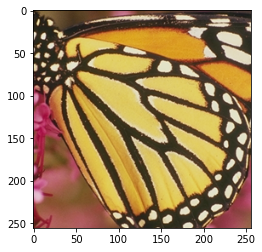

In [7]:
plt.imshow(inImage)
plt.show()

## Dimension  reformating!
First, image is read. The read image has a dimension of (256, 256, 3) that follows the (width, height, channel) format. One has to notice that while ___imshow___ method of ___matplotlib___ library expects the input image to follow the (width, height, channel) format ___pytorch___ library does not like this format and the input data/image needs to be reformated to (channel, width, height) shape. The first method that may pop up in ones head is to use ___numpy.reshape___ command to turn the (256, 256, 3) to (3, 256, 256) format. While this, certainly, can be done but it is ___WRONG___! The correct way of changing the format is to use ___moveaxis___ method of ___numpy___ library instead of ___reshape___ method. The reason is that reshape only changes the number of elements along each axis but does not change the order of the axes while moveaxis method, actually, changes the order of the axes. In the case of reshape method the first axis (most left counter) ___still___ corresponds to the ___color___ channel but this time the color channel can run to 256 while the height channel can only run to 3. That means on the color channel (left most counter) every three counter colors are repeated while the last counter (right most counter) that still corresponds to height can run until 3 meaning that only the first three rows of the image will be accessible. For instance, the element (15, 0, 1) corresponds to the blue channel of the pixel in the first first column and second row. However, ___moveaxis___ method of numpy resolves this issue by moving the axes of the image matrix. So this time the most left counter becomes width while the right most counter becoms color channel as is expected by ___pytorch___! Also, note that the reformatting of the tensors in pytoch is done using ___unsqueeze___ method! Also, note that the initial data type of the image is ___unint8___ so we change the data type to ___float32___ using ___float___ method! The data type conversion is essential just like reshaping otherwise the model won't run and will spit out the following ___runtime___ error message!

> RuntimeError: _thnn_conv2d_forward not supported on CPUType for Byte

In [8]:
#imImage  = inImage.reshape(3, 256, 256)
imImage  = numpy.moveaxis(inImage, -1, 0)
imageTen = torch.from_numpy(imImage).float()
print(imageTen.shape)
imageTen = imageTen.unsqueeze(0)
print(imageTen.shape)
print(imageTen.dtype)

torch.Size([3, 256, 256])
torch.Size([1, 3, 256, 256])
torch.float32


# Running our first model
Note that ___f1___ stands for first function that is applied in the first layer (the first hidden layer). Subsequent functions/hidden layers (f2, f3, ...) can be added. Also, note that the ___bias___ is by default added by pytorch that is why we did not initiate a bias layer in the model construction class in the cell above. At this point only one convolutino layer is applied to the input image. This process is a ___linear___ step since we have not added any activation/non-linear layer yet!

In [9]:
model = Srcnn()
f1 = model.forward(imageTen)
f1.shape

torch.Size([1, 3, 248, 248])

## Weight extraction and visualisation (and Bias)!
Note that in the extraction ___for___ loop below you can extract ___bias___ too. 

conv2d.weight torch.Size([3, 3, 9, 9])
*****
conv2d.bias torch.Size([3])
*****


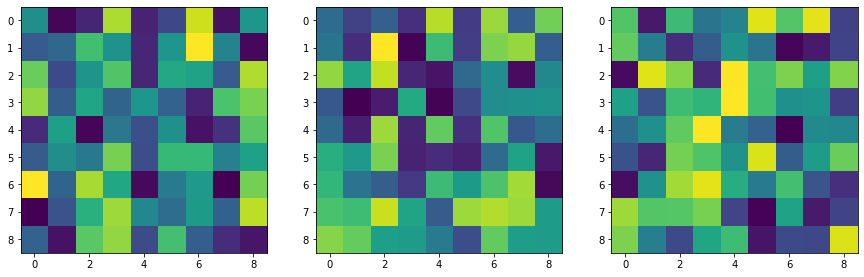

In [10]:
weights = []
count = 0
for name, param in model.named_parameters():
    print(name, param.shape)
    print("*****")
    weights.append(param[count])
    count += 1

    # visualisation section
fig, axs = plt.subplots(1, len(weights[0]), figsize = (15,15))
for i in range(len(weights) + 1):
    axs[i].imshow(weights[0][i].detach())#, cmap='gray')
plt.show()

## Feature map visualisation
The following feature map is the result of applying the ___N___ number of convolution filters to the input image. See the ___class cell___ above for more details on the number of input channels and output channels. Also, note that since we are not adding any padding in the convolution layer the dimension of the feature map has dropped from ___256 x 256___ to ___248 x 248___ as a result of using a convolution kernel of size ___9 x 9___.

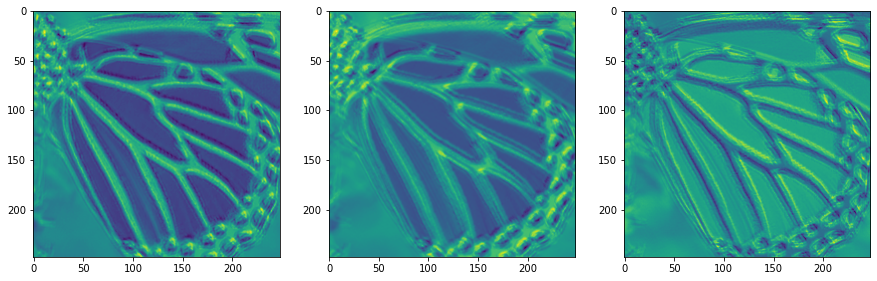

In [11]:
fig, axs = plt.subplots(1, 3, figsize = (15,15))
for i in range(3):
    axs[i].imshow(f1[0, i].detach())#, cmap='gray')

plt.show()

## Color image

In the following we take the three generated feature maps of the first convolution layer and use them as the three RGB bands of a color image. Note that the image has been reduced in size compared to the original input image (butterfly image). Also, note that the minimum value of the generated feature maps could well fall into the negative range of real values! Eventhough, ___imshow___ takes care of this problem but negative numbers make the interpretation of the resulting RGB image hard. Note that, when I used ___moveaxis___ method of numpy instead of ___reshape___ method the box-like pattern in the final image output disappeared!!!

In [12]:
f1.detach().min()

tensor(-317.4802)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


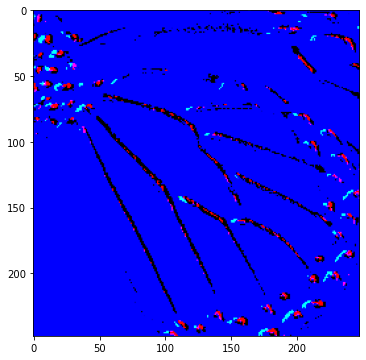

In [13]:
fig, axs = plt.subplots(1, 1, figsize = (6,6))
axs.imshow(numpy.moveaxis(f1[0].detach().numpy(), 0, -1))#, cmap='gray') # gray wont work because it is a 3-channel image.
plt.show()

## Activation layer (ReLu)

Next, we apply a non-linear opperation on the output of the first layer. That is we apply a ___Rectified Linear Unit___ activation function to each of the output feature maps of the first layer of convolution. This way the resulting features maps will be the outcome of a non-linear process instead of a purely linear process. For that we define the class once again but this time we add the activation layer to our class too!

In [14]:
class Srcnn(nn.Module):
    def __init__(self, channel1 = 3):
        super().__init__()
        self.channel1 = channel1
        self.conv2d    = nn.Conv2d(3, channel1, kernel_size = 9, padding  = 0)
        self.active1   = nn.ReLU() # we added this line
    
    def forward(self, x):
        out = self.conv2d(x)
        out = self.active1(out) # The output of conv2d becomes the input of Relu layer!
        return out

In [17]:
model2 = Srcnn() # I changed the name from model to model2
f1a1   = model2.forward(imageTen) # also from f1 to f1a1 where a1 statnds for first activation layer.
f1a1.shape

torch.Size([1, 3, 248, 248])

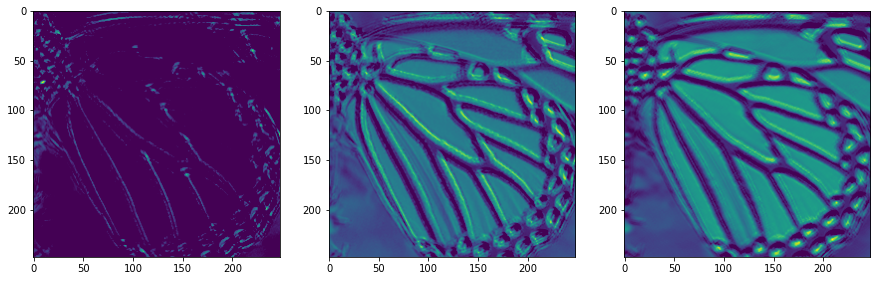

In [18]:
fig, axs = plt.subplots(1, 3, figsize = (15,15))
for i in range(3):
    axs[i].imshow(f1a1[0, i].detach())#, cmap='gray')
plt.show()

Note that after applying ___ReLu___ activation function there is no more negative numbers in our feature maps (see below where the min value of f1a1 is ___zero___ while the first model without a ___ReLu___ function contains ___negative___ values).

In [19]:
print(f1a1[0, 0].min(), f1[0, 0].min())

tensor(0., grad_fn=<MinBackward1>) tensor(-172.4538, grad_fn=<MinBackward1>)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


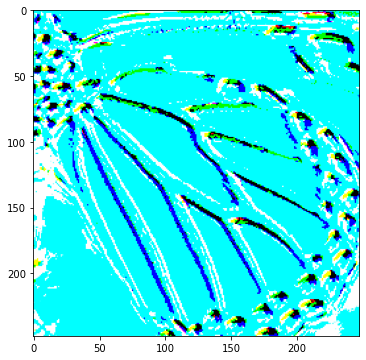

In [20]:
fig, axs = plt.subplots(1, 1, figsize = (6,6))
axs.imshow(numpy.moveaxis(f1a1[0].detach().numpy(), 0, -1))
plt.show()

## 1 x 1 Convolution and ReLu
In the second layer, we add another convolution layer but this time with a kernel size of ___1 x 1___. Next, the resulting feature map (this time one single feature map) will be fed to another ___ReLu___ function. Read [this](https://machinelearningmastery.com/introduction-to-1x1-convolutions-to-reduce-the-complexity-of-convolutional-neural-networks/) for more details.

In [21]:
class Srcnn(nn.Module):
    def __init__(self, channel1 = 3):
        super().__init__()
        self.channel1 = channel1
        self.conv2d1  = nn.Conv2d(3, channel1, kernel_size = 9, padding = 0)
        self.active   = nn.ReLU()
        self.conv2d2  = nn.Conv2d(channel1, 1, kernel_size = 1, padding = 0) # new layer
        
    def forward(self, x):
        out = self.conv2d1(x)
        out = self.active(out)
        out = self.conv2d2(out)  # new layer
        out = self.active(out)   # new layer
        return out

In [22]:
model3 = Srcnn()
f2a2   = model3.forward(imageTen)
f2a2.shape

torch.Size([1, 1, 248, 248])

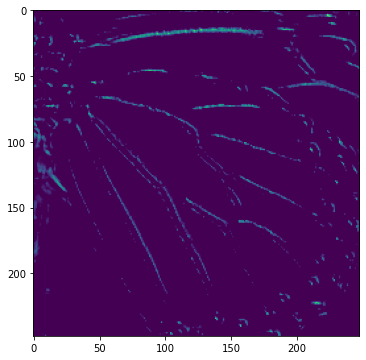

In [23]:
fig, axs = plt.subplots(1, 1, figsize = (6,6))
axs.imshow(f2a2[0, 0].detach())#, cmap='gray')
plt.show()

# Adding the third layer (f3)

Here we add one more layer with a kernel size of ___5 x 5___. We apply this kerlnel to the resulting single feature map of the second layer (output of the ___1 x 1___ kernel) to generate three feature maps (one for each of the R, G, and B color channels) so that we can create one final ___image___ as the final output of our model.

In [175]:
class Srcnn(nn.Module):
    def __init__(self, channel1 = 3):
        super().__init__()
        self.channel1 = channel1
        self.conv2d1  = nn.Conv2d(3, channel1, kernel_size = 9, padding = 0)
        self.active   = nn.ReLU()
        self.conv2d2  = nn.Conv2d(channel1, 1, kernel_size = 1, padding = 0)
        self.conv2d3  = nn.Conv2d(1, 3, kernel_size = 5, padding = 0) # the final convolution layer
        
    def forward(self, x):
        out = self.conv2d1(x)
        out = self.active(out)
        out = self.conv2d2(out)
        out = self.active(out)
        out = self.conv2d3(out)   # the final convolution
        return out

In [25]:
model4 = Srcnn()
f3     = model4.forward(imageTen)
f3.shape

torch.Size([1, 3, 244, 244])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


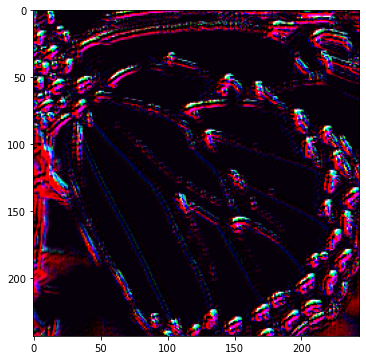

In [26]:
fig, axs = plt.subplots(1, 1, figsize = (6,6))
axs.imshow(numpy.moveaxis(f3[0].detach().numpy(), 0, -1))
plt.show()

# Data preparation

In the following, I introduce three functions that, later, will be used in our ___SRCNN___ model. The first one is a function called ___random Cropper___ which takes an input image and outputs a list of smaller images (i.e. sub-images) of fixed size (32 x 32 by default) that are randomly cropped out of the input image. For each input image the function (by default) generates 10 sub-images. These sub-images will be our high resolution (___HR___) sample. Next, we use these HR images to another function called ___blurring___. The name is self-explanatory. This function takes each sub image and outputs a blurred version of the image. The blurring is done using a simple ___Gaussian___ filter. Finally, the outputs of the blurring function will be fed to the last function that is called ___upscaling___. This function takes the input blurred sub-images and generates a list of upscaled images using a ___Bicubic___ filter. By default this function upscales the input images by a factor of 2. For instance, the input 32 x 32 images are upscaled to 64 x 64 images. These output images will comprise our sample of low resolution ___LR___ images.

In [103]:
import random
from PIL import Image
from pathlib import Path

def randomCropper(inputList, wh = 32, sample = 10, outputPath = "./train/hr"):
#     inImg = Image.open(inputPath)
    
    cropList = []
    for image in inputList:
        print(image, type(image))
        imgW, imgH = image.size
        count = 0
        while count < sample:
            randW = random.randint(0, imgW - wh)
            randH = random.randint(0, imgH - wh)
            if (randW + wh < imgW) and (randH + wh < imgH):
                cropped = image.crop(box = (randW, randH, randW + wh, randH + wh))
                cropList.append(cropped)
                cropped.save(outputPath + "/t" + str(count) + ".png","PNG")
                count += 1
            else:
                pass
    return cropList

In [96]:
def blurring(inputList, outputPath = "./train/lr"):
    blurredList = []
    count = 0
    for image in inputList:
        blurredImg = image.filter(ImageFilter.GaussianBlur())
        blurredImg.save(outputPath + "/t" + str(count) + ".png","PNG")
        count += 1
    return blurredList

In [98]:
def upscaling(inputList, upFactor = 2, outputPath = "./train"):
    upscaledList = []
    count = 0
    for image in inputList:
        upscaledImg = image.resize((image.size[0] * upFactor, image.size[0] * upFactor), \
                                     resample = PIL.Image.BICUBIC)
        upscaledImg.save(outputPath + "/t" + str(count) + ".png", "PNG")
        count += 1
        upscaledList.append(upscaledImg)
    return upscaledList

Here I am uising all 

In [160]:
from pathlib import Path

def imageProcessor(inputPath = "./data/", wh = 32, sample = 10, upFactor = 2, \
                   cropOutPath = "./train/hr/", upscaleOutPath = "./train/lr/"):
    """This function ..."""
    
    cropList     = []
    upscaledList = []
    result       = [] 
    imagePath = Path(inputPath)
    fileList  = [f for f in os.listdir(imagePath) if os.path.isfile(os.path.join(imagePath, f))]
    for file in fileList:
        if file == ".DS_Store":
            continue
        inImg = Image.open(os.path.join(imagePath, file))
        imgW, imgH = inImg.size
        
        cCounter    = 0
        while cCounter < sample:
            randW = random.randint(0, imgW - wh)
            randH = random.randint(0, imgH - wh)
            if (randW + wh < imgW) and (randH + wh < imgH):
                cropped = inImg.crop(box = (randW, randH, randW + wh, randH + wh))
                cropped.save(cropOutPath + str(file) + "_h" + str(cCounter) + ".png","PNG")
                #cropList.append(cropped)
                
                # Gaussian blurring
                blurredImg = cropped.filter(ImageFilter.GaussianBlur())
                
                # Bicubic upscaling
                upscaledImg = blurredImg.resize((blurredImg.size[0] * upFactor, blurredImg.size[0] * upFactor), \
                                             resample = PIL.Image.BICUBIC)
                upscaledImg.save(upscaleOutPath + str(file) + "_l" + str(cCounter) + ".png", "PNG")
                #upscaledList.append(upscaledImg)
                cCounter += 1
                
                outTuple = (upscaledImg, cropped)
                result.append(outTuple)
#                 print("cropping counter: ", cCounter)
            else:
                pass
    return result

In [161]:
a = imageProcessor()

In [204]:
from torchvision import transforms

def dataMaker(inputSet = None):
    to_tensor = transforms.ToTensor()
    outList   = [] 
    for ii in range(len(inputSet)):
        imgL = to_tensor(a[ii][0])
        imgH = to_tensor(a[ii][1])
#         imgL = imgL.unsqueeze(0)
        out  = (imgL, imgH)
        outList.append(out)
    return outList

In [205]:
b = dataMaker(a)

In [227]:
len(b)

120

# Things to read:

https://discuss.pytorch.org/t/what-is-loss-item/61218/20


In [198]:
# Remeber that a Dataset object needs to have two methods; __len__ and __getitem__. 
# See page 16, 173 and 185 for more details. 

train_loader = torch.utils.data.DataLoader(b, batch_size=16, shuffle=True)

In [222]:
class Srcnn2(nn.Module):
    def __init__(self, channel1 = 64):
        super().__init__()
        self.channel1 = channel1
        self.conv2d1  = nn.Conv2d(3, 64, kernel_size = 9, padding = 0)
        self.conv2d2  = nn.Conv2d(64, 32, kernel_size = 1, stride = 2, padding = 0)
        self.conv2d3  = nn.Conv2d(32, 3, kernel_size = 5, padding = 4) # the final convolution layer
        self.active   = nn.ReLU()
        
    def forward(self, x):
        out = self.conv2d1(x)
        out = self.active(out)
        out = self.conv2d2(out)
        out = self.active(out)
        out = self.conv2d3(out)   # the final convolution
        return out

In [248]:
# def trainingLoop(n_epochs, optimizer, model, loss_fn, train_loader):
import datetime
from torch import optim

device    = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_epochs  = 100
loss_fn   = torch.nn.MSELoss()
model     = Srcnn2().to(device)
lrate     = 1e-3
optimizer = optim.Adam([
    {'params': model.conv2d1.parameters()},
    {'params': model.conv2d2.parameters()},
    {'params': model.conv2d3.parameters(), 'lr': lrate * 0.1}
    ], lr = lrate)

lossList  = []
epochList = []
train_loader = torch.utils.data.DataLoader(b, batch_size=16, shuffle=True, num_workers=0)
for epoch in range(1, n_epochs + 1):
    loss_train = 0.0
    for img, label in train_loader:
        output = model(img)
        loss   = loss_fn(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_train += loss.item()
        
    if epoch == 1 or epoch % 10 == 0:
        lossList.append(loss_train / len(train_loader))
        epochList.append(epoch)
        print('{} Epoch {}, Training loss {}'.format(\
            datetime.datetime.now(), epoch,\
            loss_train / len(train_loader)))


2021-01-07 23:57:08.704709 Epoch 1, Training loss 0.21804268285632133
2021-01-07 23:57:14.182120 Epoch 10, Training loss 0.049095078371465206
2021-01-07 23:57:20.365320 Epoch 20, Training loss 0.04255416430532932
2021-01-07 23:57:26.346946 Epoch 30, Training loss 0.041880667209625244
2021-01-07 23:57:32.510356 Epoch 40, Training loss 0.04010547464713454
2021-01-07 23:57:38.673827 Epoch 50, Training loss 0.03939143638126552
2021-01-07 23:57:44.774779 Epoch 60, Training loss 0.038215592969208956
2021-01-07 23:57:50.851096 Epoch 70, Training loss 0.0372098742518574
2021-01-07 23:57:56.913387 Epoch 80, Training loss 0.03591398638673127
2021-01-07 23:58:03.016527 Epoch 90, Training loss 0.035475458949804306
2021-01-07 23:58:09.166710 Epoch 100, Training loss 0.03483170154504478


## Learning rate of 1e-4.

<function matplotlib.pyplot.show(close=None, block=None)>

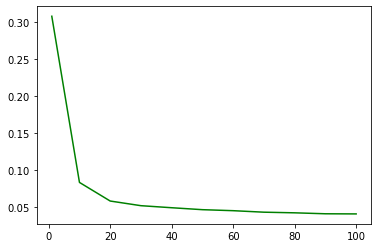

In [247]:
plt.plot(epochList, lossList, "g-")
plt.show

## Learning rate of 1e-3

<function matplotlib.pyplot.show(close=None, block=None)>

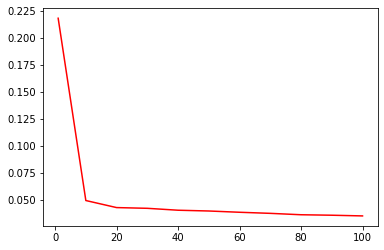

In [249]:
plt.plot(epochList, lossList, "r-")
plt.show